<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/2024_Revnb_75_25_Update_H1_T6_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


In [7]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [8]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

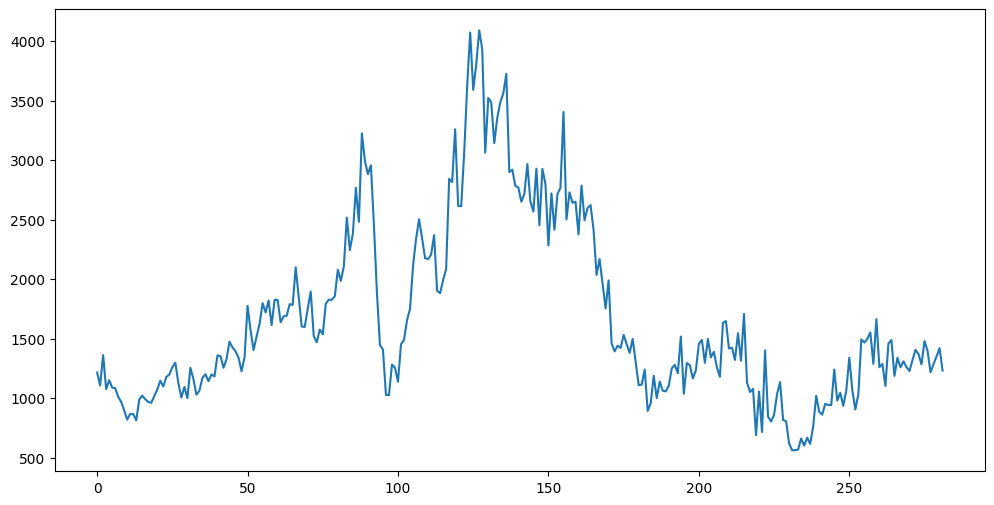

In [9]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Peramalan-LSTM_75-25/main/Ekspor-Migas-2001-2024.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [10]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
time_steps = 6
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [12]:
ytest = test
ytrain = train

In [13]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [14]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (205, 6, 1)
y_train.shape:  (205, 1)
X_test.shape:  (71, 6, 1)
y_test.shape:  (71, 1)


In [16]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [18]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [19]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-13 09:55:08,190] A new study created in memory with name: no-name-6495d5e5-da27-481d-9bfb-9c60402442cc


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 1: MSE = 0.0213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Fold 2: MSE = 0.0803


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.2873
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 4: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


[I 2024-08-13 09:55:24,663] Trial 0 finished with value: 0.08846747875213623 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.08846747875213623.


Fold 5: MSE = 0.0269
Average MSE: 0.0885
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Fold 1: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 2: MSE = 0.0664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Fold 3: MSE = 0.0869
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0086
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 09:55:41,023] Trial 1 finished with value: 0.03736107796430588 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.03736107796430588.


Fold 5: MSE = 0.0106
Average MSE: 0.0374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 1: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Fold 2: MSE = 0.0288
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 3: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Fold 4: MSE = 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2024-08-13 09:55:58,567] Trial 2 finished with value: 0.013732492923736572 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0054
Average MSE: 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 1: MSE = 0.0511
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 2: MSE = 0.0231
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 3: MSE = 0.1328
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-13 09:56:17,368] Trial 3 finished with value: 0.04515232890844345 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0111
Average MSE: 0.0452
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0905
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.1601
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Fold 3: MSE = 0.2752
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 4: MSE = 0.1026
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


[I 2024-08-13 09:56:32,399] Trial 4 finished with value: 0.1262262463569641 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0028
Average MSE: 0.1262
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 1: MSE = 0.0370
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 2: MSE = 0.0214
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 3: MSE = 0.1562
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


[I 2024-08-13 09:56:51,957] Trial 5 finished with value: 0.044885970652103424 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0040
Average MSE: 0.0449
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Fold 2: MSE = 0.0398
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 3: MSE = 0.0322
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0072
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


[I 2024-08-13 09:57:11,740] Trial 6 finished with value: 0.020688023418188095 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0030
Average MSE: 0.0207
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 1: MSE = 0.0137
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 2: MSE = 0.0358
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 3: MSE = 0.1025
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2024-08-13 09:57:29,967] Trial 7 finished with value: 0.03398767113685608 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0054
Average MSE: 0.0340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 1: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Fold 2: MSE = 0.0282
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 3: MSE = 0.0462
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2024-08-13 09:57:47,199] Trial 8 finished with value: 0.020029649138450623 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0027
Average MSE: 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Fold 2: MSE = 0.0225
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 3: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Fold 4: MSE = 0.0381
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2024-08-13 09:58:05,044] Trial 9 finished with value: 0.018562035635113716 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.013732492923736572.


Fold 5: MSE = 0.0031
Average MSE: 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 2: MSE = 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 3: MSE = 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Fold 4: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


[I 2024-08-13 09:58:24,829] Trial 10 finished with value: 0.01047799177467823 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0031
Average MSE: 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Fold 2: MSE = 0.0536
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 3: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Fold 4: MSE = 0.0450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2024-08-13 09:58:44,872] Trial 11 finished with value: 0.027035381644964218 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0093
Average MSE: 0.0270
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Fold 2: MSE = 0.0480
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 3: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 4: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


[I 2024-08-13 09:59:05,265] Trial 12 finished with value: 0.018990570679306984 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0027
Average MSE: 0.0190
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 1: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 2: MSE = 0.0343
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 3: MSE = 0.0162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Fold 4: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 09:59:22,735] Trial 13 finished with value: 0.015876559540629387 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0089
Average MSE: 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 1: MSE = 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 2: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 3: MSE = 0.0634
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 4: MSE = 0.0609
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2024-08-13 09:59:39,216] Trial 14 finished with value: 0.032388895750045776 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0026
Average MSE: 0.0324
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Fold 1: MSE = 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 2: MSE = 0.0349
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 3: MSE = 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 4: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2024-08-13 09:59:57,332] Trial 15 finished with value: 0.015813462436199188 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0033
Average MSE: 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 2: MSE = 0.0306
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 3: MSE = 0.0159
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Fold 4: MSE = 0.0072
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


[I 2024-08-13 10:00:14,917] Trial 16 finished with value: 0.014508381485939026 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0036
Average MSE: 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 1: MSE = 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Fold 2: MSE = 0.0221
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 3: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 4: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 10:00:30,444] Trial 17 finished with value: 0.013757008127868176 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0054
Average MSE: 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 1: MSE = 0.1910
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 2: MSE = 0.1189
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 3: MSE = 0.2150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Fold 4: MSE = 1.1592
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


[I 2024-08-13 10:00:49,565] Trial 18 finished with value: 0.4205489158630371 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.4186
Average MSE: 0.4205
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 1: MSE = 0.0901
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 2: MSE = 0.1028
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 3: MSE = 0.3652
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 4: MSE = 0.1418
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 10:01:03,117] Trial 19 finished with value: 0.14063546061515808 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0033
Average MSE: 0.1406
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 2: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 3: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 4: MSE = 0.0499
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2024-08-13 10:01:19,077] Trial 20 finished with value: 0.023155080154538155 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0076
Average MSE: 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 1: MSE = 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 2: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 3: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 4: MSE = 0.0296
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


[I 2024-08-13 10:01:35,249] Trial 21 finished with value: 0.015074441209435463 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0031
Average MSE: 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 1: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 2: MSE = 0.0311
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 3: MSE = 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 4: MSE = 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2024-08-13 10:01:52,978] Trial 22 finished with value: 0.014922009781002998 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 10 with value: 0.01047799177467823.


Fold 5: MSE = 0.0033
Average MSE: 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 1: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 2: MSE = 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 3: MSE = 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Fold 4: MSE = 0.0071
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 10:02:09,918] Trial 23 finished with value: 0.010347279720008373 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0061
Average MSE: 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 1: MSE = 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 2: MSE = 0.0254
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 3: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 4: MSE = 0.0424
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


[I 2024-08-13 10:02:28,694] Trial 24 finished with value: 0.0201877448707819 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0051
Average MSE: 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 1: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 2: MSE = 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 3: MSE = 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Fold 4: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


[I 2024-08-13 10:02:44,532] Trial 25 finished with value: 0.012228905223309994 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0060
Average MSE: 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 1: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 2: MSE = 0.0363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 3: MSE = 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 4: MSE = 0.0072
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2024-08-13 10:03:01,269] Trial 26 finished with value: 0.015822801738977432 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0077
Average MSE: 0.0158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 1: MSE = 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 2: MSE = 0.0244
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Fold 3: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Fold 4: MSE = 0.0235
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


[I 2024-08-13 10:03:21,146] Trial 27 finished with value: 0.015355040319263935 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0038
Average MSE: 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 1: MSE = 0.1095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 2: MSE = 1.0524
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 3: MSE = 0.0643
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 4: MSE = 0.0673
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 10:03:38,175] Trial 28 finished with value: 0.2660197615623474 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0365
Average MSE: 0.2660
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Fold 1: MSE = 0.0639
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 2: MSE = 0.1344
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 3: MSE = 0.3781
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 4: MSE = 0.1517
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


[I 2024-08-13 10:03:54,989] Trial 29 finished with value: 0.14620156586170197 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0029
Average MSE: 0.1462
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 1: MSE = 0.0358
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 2: MSE = 0.0842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 3: MSE = 0.2617
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 4: MSE = 0.0238
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


[I 2024-08-13 10:04:07,939] Trial 30 finished with value: 0.08534920960664749 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0213
Average MSE: 0.0853
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 1: MSE = 0.0157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 2: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 3: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2024-08-13 10:04:23,591] Trial 31 finished with value: 0.011771301738917828 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0034
Average MSE: 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 1: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 2: MSE = 0.0323
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 3: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 4: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2024-08-13 10:04:38,728] Trial 32 finished with value: 0.014532459899783134 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0040
Average MSE: 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 1: MSE = 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Fold 2: MSE = 0.0356
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 3: MSE = 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 4: MSE = 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2024-08-13 10:04:57,440] Trial 33 finished with value: 0.014908802695572376 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0052
Average MSE: 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 1: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Fold 2: MSE = 0.0312
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 3: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 4: MSE = 0.0397
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2024-08-13 10:05:12,943] Trial 34 finished with value: 0.02146342024207115 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0074
Average MSE: 0.0215
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 1: MSE = 0.0952
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 2: MSE = 0.7018
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 3: MSE = 0.0482
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 4: MSE = 0.2586
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2024-08-13 10:05:28,341] Trial 35 finished with value: 0.2502347230911255 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.1473
Average MSE: 0.2502
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 1: MSE = 0.0564
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 2: MSE = 0.0772
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Fold 3: MSE = 0.1850
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 4: MSE = 0.0244
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[I 2024-08-13 10:05:40,690] Trial 36 finished with value: 0.07410554587841034 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0276
Average MSE: 0.0741
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Fold 1: MSE = 0.0121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 2: MSE = 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 3: MSE = 0.0220
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2024-08-13 10:05:59,127] Trial 37 finished with value: 0.012274236418306828 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0021
Average MSE: 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 1: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 2: MSE = 0.0314
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 3: MSE = 0.0421
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Fold 4: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2024-08-13 10:06:14,020] Trial 38 finished with value: 0.020641572773456573 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0069
Average MSE: 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 1: MSE = 0.0188
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 2: MSE = 2.0771
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Fold 3: MSE = 1.7030
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 4: MSE = 1.5404
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2024-08-13 10:06:31,960] Trial 39 finished with value: 1.068989634513855 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0055
Average MSE: 1.0690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 1: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 2: MSE = 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Fold 3: MSE = 0.0233
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2024-08-13 10:06:49,795] Trial 40 finished with value: 0.01350738387554884 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0026
Average MSE: 0.0135
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 2: MSE = 0.0179
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Fold 3: MSE = 0.0270
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


[I 2024-08-13 10:07:06,517] Trial 41 finished with value: 0.013934100046753883 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0023
Average MSE: 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 1: MSE = 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Fold 2: MSE = 0.0176
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 3: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2024-08-13 10:07:23,257] Trial 42 finished with value: 0.012246988713741302 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0021
Average MSE: 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 1: MSE = 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 2: MSE = 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Fold 3: MSE = 0.0266
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Fold 4: MSE = 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


[I 2024-08-13 10:07:41,179] Trial 43 finished with value: 0.014696258120238781 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0039
Average MSE: 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 1: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 2: MSE = 0.0175
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


[I 2024-08-13 10:07:58,191] Trial 44 finished with value: 0.012144534848630428 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0021
Average MSE: 0.0121
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Fold 1: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 2: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 3: MSE = 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


[I 2024-08-13 10:08:20,141] Trial 45 finished with value: 0.012852693907916546 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0026
Average MSE: 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Fold 2: MSE = 0.0323
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Fold 3: MSE = 0.0465
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 4: MSE = 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


[I 2024-08-13 10:08:36,312] Trial 46 finished with value: 0.02083810791373253 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0026
Average MSE: 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Fold 1: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Fold 2: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 3: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


[I 2024-08-13 10:08:53,838] Trial 47 finished with value: 0.011099869385361671 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0024
Average MSE: 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Fold 1: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Fold 2: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Fold 3: MSE = 0.0183
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


[I 2024-08-13 10:09:09,869] Trial 48 finished with value: 0.011827084235846996 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0026
Average MSE: 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Fold 1: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Fold 2: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 3: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


[I 2024-08-13 10:09:26,018] Trial 49 finished with value: 0.010584279894828796 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 23 with value: 0.010347279720008373.


Fold 5: MSE = 0.0025
Average MSE: 0.0106
Best parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}
Best value: 0.010347279720008373


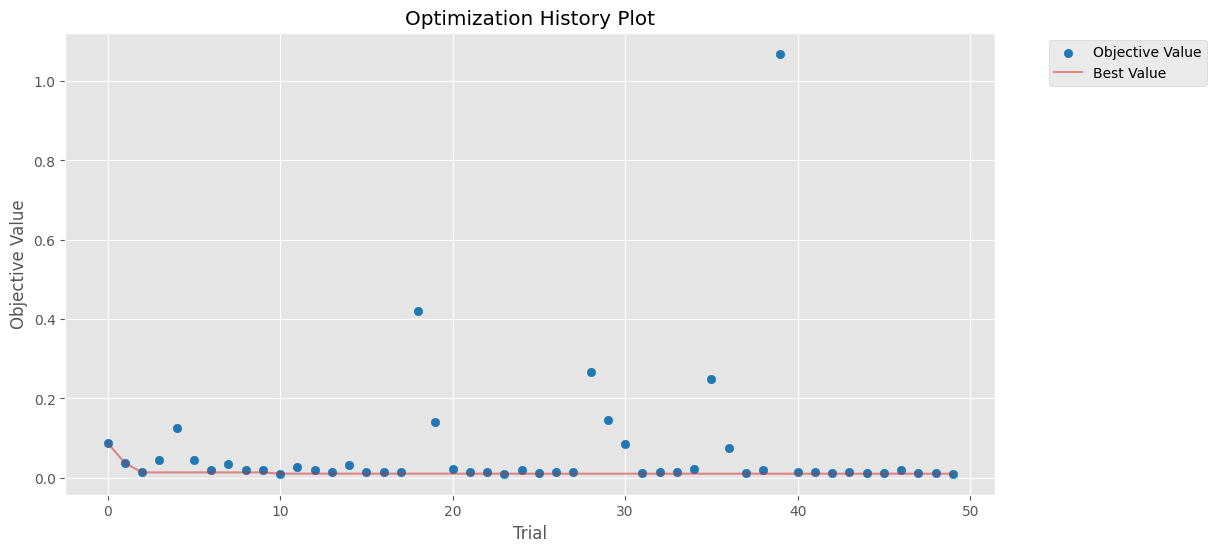

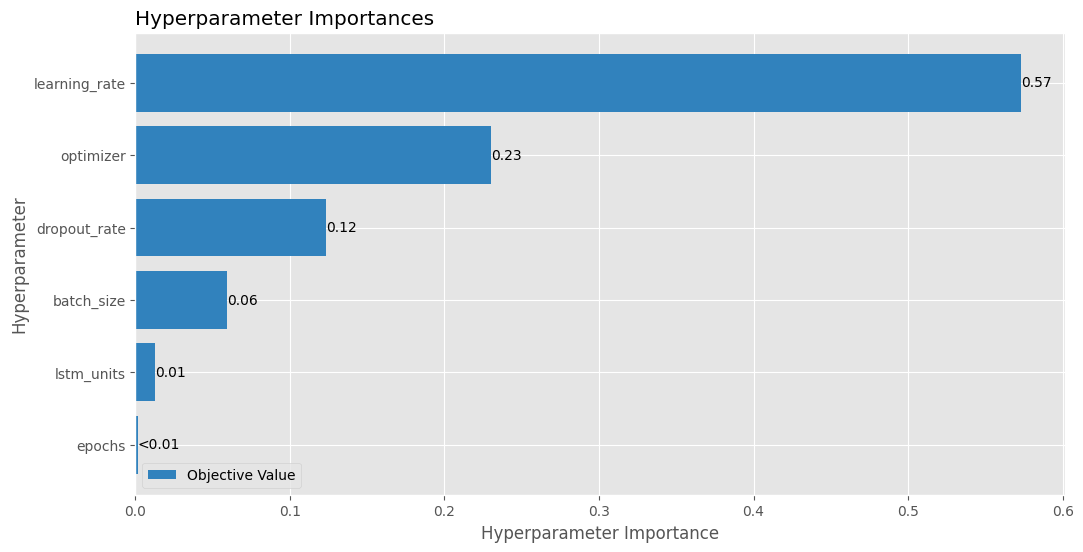

In [20]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [21]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.2230 - val_loss: 0.0949
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0874 - val_loss: 0.0118
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0220 - val_loss: 0.0188
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0187 - val_loss: 0.0091
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158 - val_loss: 0.0065
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0158 - val_loss: 0.0301
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0391 - val_loss: 0.0049
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - val_loss: 0.0116
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0169 - val_loss: 0.0024
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0278 - val_loss: 0.0027
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0162 - val_loss: 0.0131


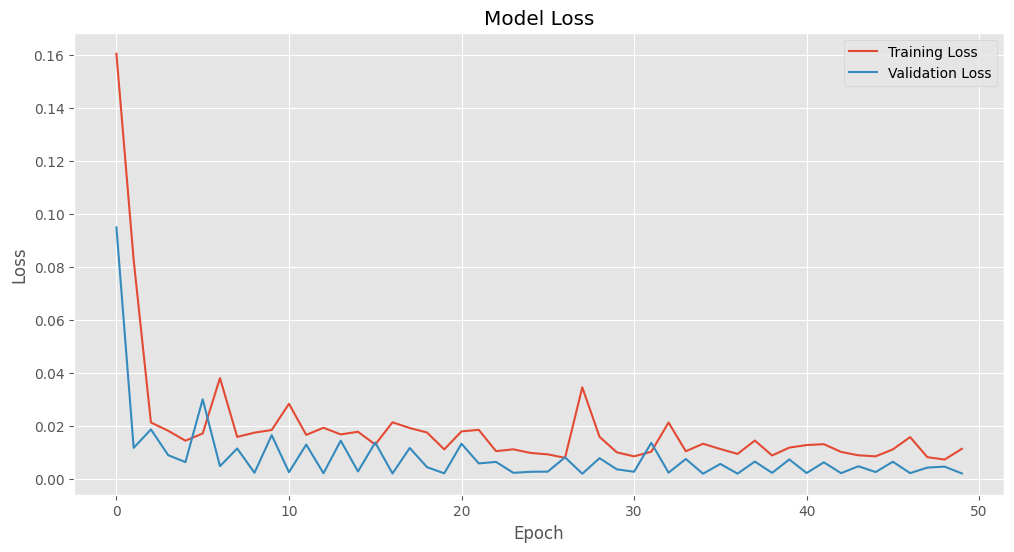

Average Loss: 0.0192


In [22]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [23]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [24]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [26]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 199.393
Root Mean Square Error: 278.033
Mean Absolute Percentage Error: 10.017%

evaluasi model data test:
Mean Absolute Error: 152.451
Root Mean Square Error: 191.171
Mean Absolute Percentage Error: 14.636%



In [27]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

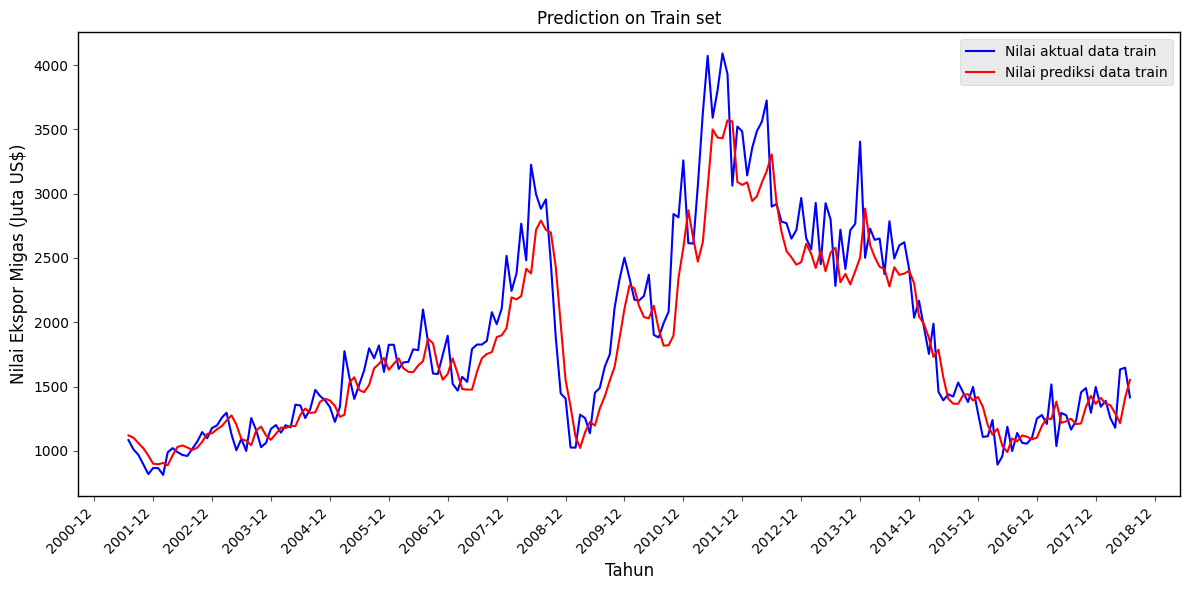

In [28]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

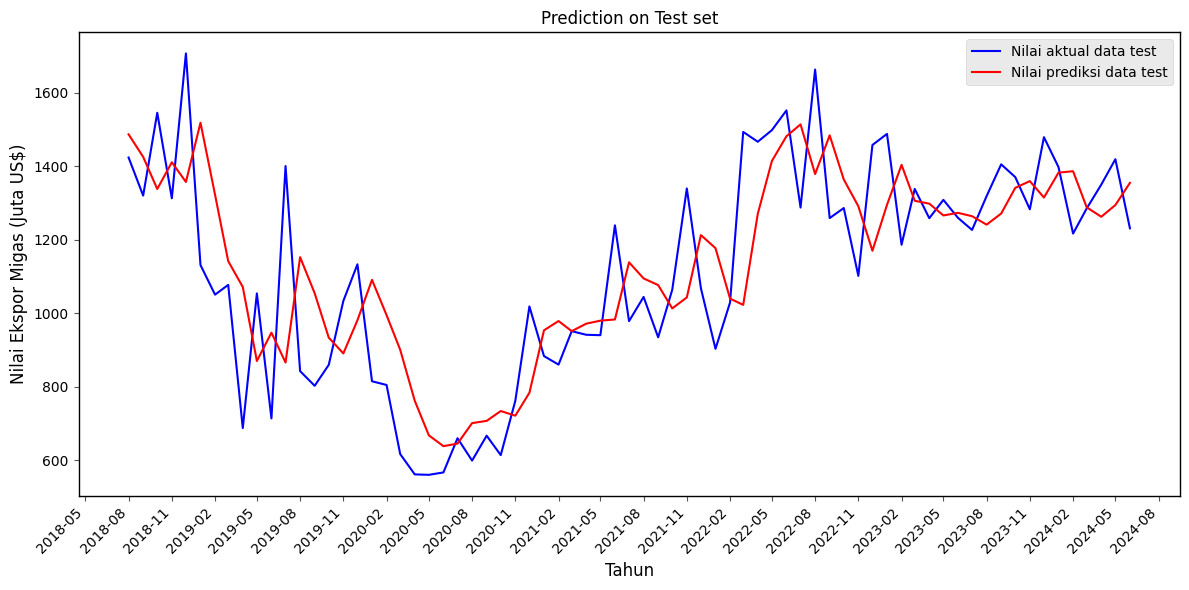

In [29]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

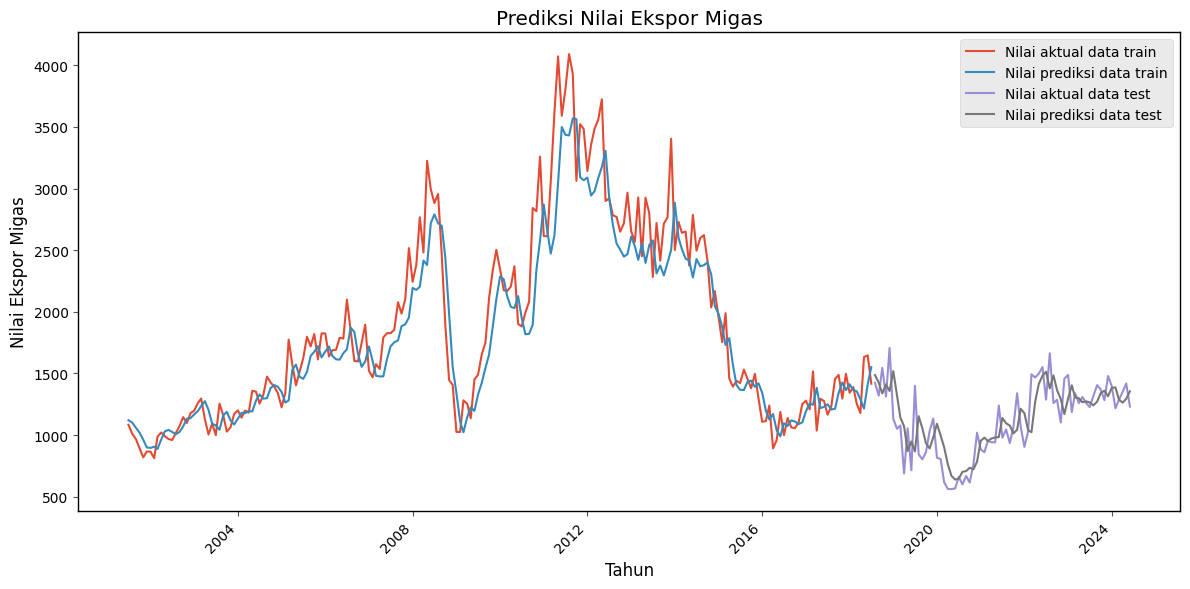

In [30]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-07-01                     1294.459595
1  2024-08-01                     1278.747070
2  2024-09-01                     1266.483276
3  2024-10-01                     1258.585815
4  2024-11-01                     1253.368896
5  2024-12-01                     1250.242920
6  2025-01-01                     1245.060913
7  2025-02-01                     1241.825684
8  2025-03-01                     1238.909058
9  2025-04-01                     1236.316895
10 2025-05-01                     1234

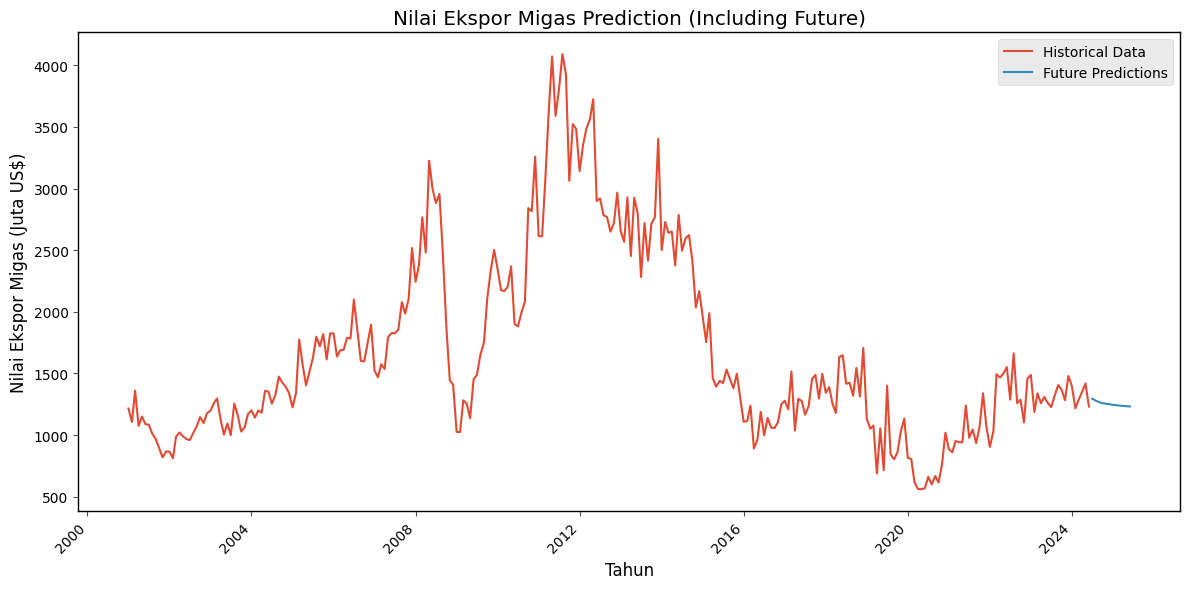

In [31]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


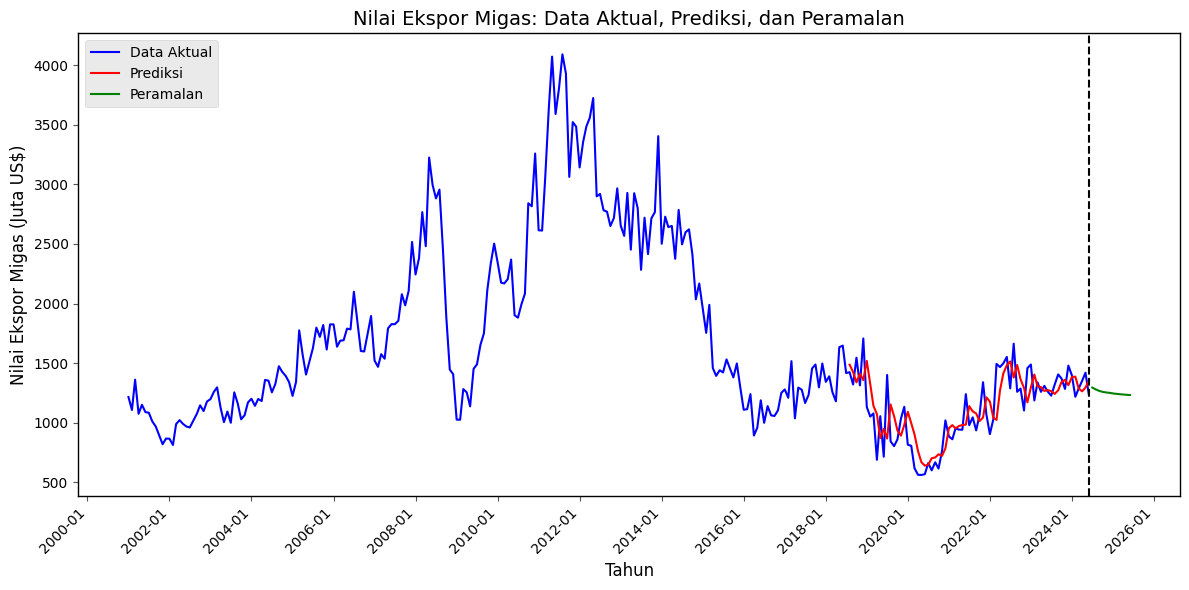

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [33]:
!pip install openpyxl

In [34]:
forecast_df.to_excel('forecast_2024-75:25_h1t6.xlsx', index=False)
from google.colab import files
files.download('forecast_2024-75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_2024-75:25_h1t6.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_2024-75:25_h1t6.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>